### 1. Импорт библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec

[nltk_data] Downloading package punkt to /home/avm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/avm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/avm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/avm/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import regex
from tqdm import tqdm
import pickle
import os
import inspect
import sys
from icecream import ic

In [ ]:
base_dir = 'data_out'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

<font color='green'>
 шаблон пометок   
<br>    
<br>    

### 2. Загрузка данных

In [ ]:
train_df=pd.read_csv('data/twitter_training.csv')
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
train_df.columns=['TweetID','entity','sentiment','Tweet content']
train_df.head()

,TweetID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
val_df = pd.read_csv('data/twitter_validation.csv')
val_df

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
val_df.columns=['TweetID','entity','sentiment','Tweet content']
val_df.head()

,TweetID,entity,sentiment,Tweet content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


<font color='green'>
    TweetID -  id твита
<br>
    entity - сущность, которой твит посвящен
<br>
    sentiment - целевая переменная - метка настроения
<br>
    Tweet content - содержание твита
<br>    

In [ ]:
train_df.sentiment.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

<font color='green'>
    Positive -  позитивный отзыв
<br>
    Neutral - нейтральный отзыв
<br>
    Negative - негативный отзыв
<br>
    Irrelevant - ошибочный отзыв не по теме
<br>    

### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   Tweet content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
train_df = train_df.drop_duplicates()
train_df.shape

(71981, 4)

In [ ]:
train_df.isnull().sum()

TweetID            0
entity             0
sentiment          0
Tweet content    326
dtype: int64

In [ ]:
train_df = train_df.dropna()
train_df.isnull().sum()

TweetID          0
entity           0
sentiment        0
Tweet content    0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71655 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        71655 non-null  int64 
 1   entity         71655 non-null  object
 2   sentiment      71655 non-null  object
 3   Tweet content  71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        999 non-null    int64 
 1   entity         999 non-null    object
 2   sentiment      999 non-null    object
 3   Tweet content  999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [ ]:
val_df = val_df.drop_duplicates()
val_df.shape

(999, 4)

In [ ]:
val_df.isnull().sum()

TweetID          0
entity           0
sentiment        0
Tweet content    0
dtype: int64

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        999 non-null    int64 
 1   entity         999 non-null    object
 2   sentiment      999 non-null    object
 3   Tweet content  999 non-null    object
dtypes: int64(1), object(3)
memory usage: 39.0+ KB


In [ ]:
train_df.loc[train_df['sentiment'] == 'Irrelevant', 'sentiment'] = 'Neutral'
val_df.loc[val_df['sentiment'] == 'Irrelevant', 'sentiment'] = 'Neutral'

In [ ]:
train_df.sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [ ]:
val_df.sentiment.unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

<font color='green'>
     Тренировочную выборку почистили от пропусков и дубликатов.   
<br>
     Проверочная выборка проблем не имела.
<br>
     Заменили класс 'Irrelevant', высказываний не по теме на 'Neutral', т.к. по смыслу задания это на результат не влияет, но данные упрощает - 3 класса вместо 4, и очищает, т.к. "не по теме" очень размытый критерий.

### 4. EDA

**Описательная статистика, поиск взаимосвязей**

<font color='green'>
     Посмотрим на распределение целевой переменной.   
<br>
     
<br>  

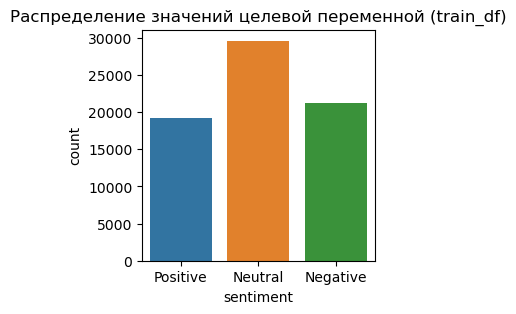

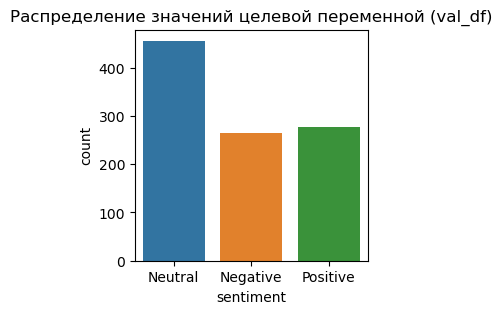

In [ ]:
plt.figure(figsize=(3, 3))
sns.countplot(x='sentiment', data=train_df)
plt.title('Распределение значений целевой переменной (train_df)')
plt.show()

plt.figure(figsize=(3, 3))
sns.countplot(x='sentiment', data=val_df)
plt.title('Распределение значений целевой переменной (val_df)')
plt.show()

<font color='green'>
     Большой разбаллансировки не наблюдается.   
<br>
     С этой стороны дополнительно можно ничего не предпринимать.
<br>  
    Посмотрим на это в разрезе сущностей.

In [ ]:
train_df.entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [ ]:
len(train_df.entity.unique())

32

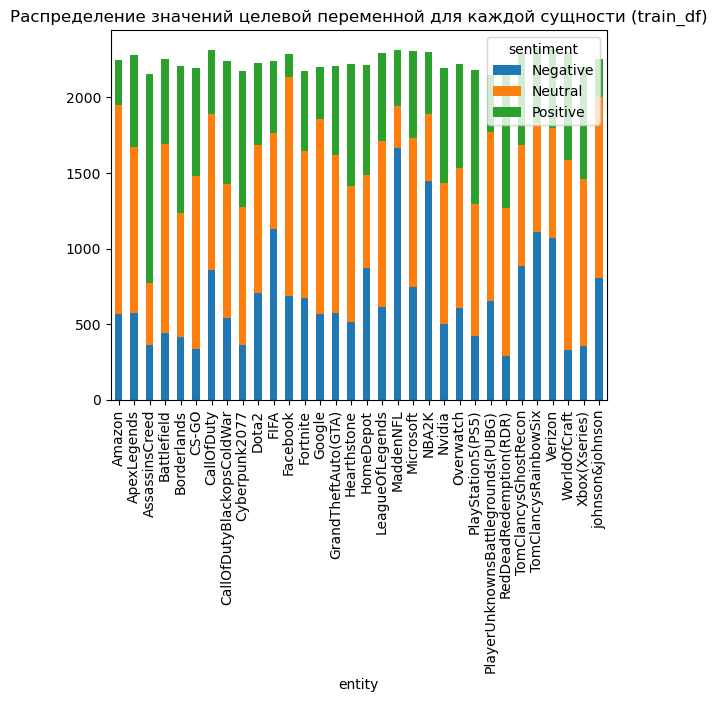

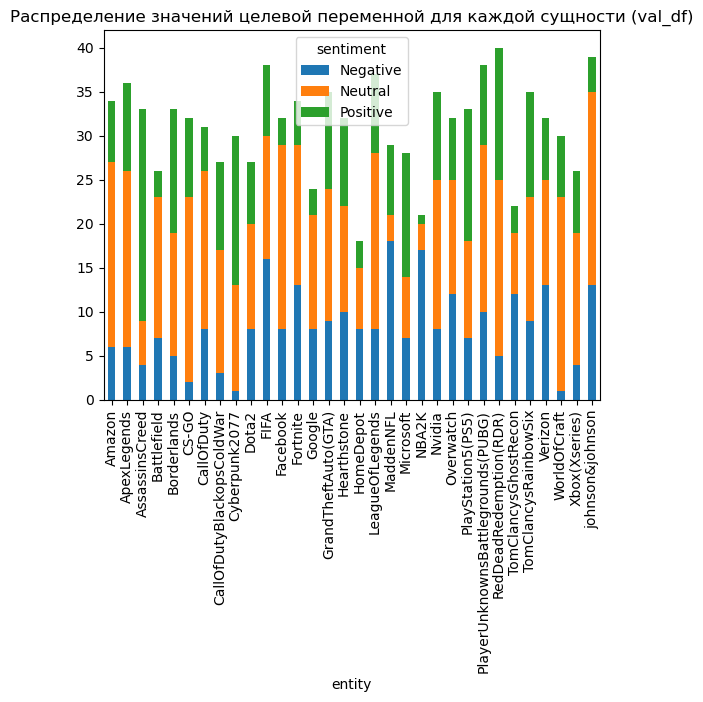

In [ ]:
entity_sentiment_counts_train_df = train_df.groupby(['entity', 'sentiment']).size().unstack()
entity_sentiment_counts_train_df.plot(kind='bar', stacked=True)
plt.title('Распределение значений целевой переменной для каждой сущности (train_df)')
plt.show()

entity_sentiment_counts_val_df = val_df.groupby(['entity', 'sentiment']).size().unstack()
entity_sentiment_counts_val_df.plot(kind='bar', stacked=True)
plt.title('Распределение значений целевой переменной для каждой сущности (val_df)')
plt.show()

<font color='green'>
     В принципе тоже большой разбаллансировки не наблюдается, хотя разнообразие налицо.   
<br>
     
<br>  
    

In [ ]:
train_df['Tweet content'].map(len).describe()

count    71655.000000
mean       110.538930
std         79.410111
min          1.000000
25%         49.000000
50%         93.000000
75%        155.000000
max        957.000000
Name: Tweet content, dtype: float64

<font color='green'>
     Длина твитов сильно варьируется.   
<br>
     
<br>  
    

In [ ]:
train_df.groupby(['entity'])['sentiment'].count()

entity
Amazon                               2249
ApexLegends                          2278
AssassinsCreed                       2156
Battlefield                          2255
Borderlands                          2205
CS-GO                                2195
CallOfDuty                           2314
CallOfDutyBlackopsColdWar            2242
Cyberpunk2077                        2175
Dota2                                2225
FIFA                                 2238
Facebook                             2289
Fortnite                             2176
Google                               2199
GrandTheftAuto(GTA)                  2208
Hearthstone                          2219
HomeDepot                            2216
LeagueOfLegends                      2296
MaddenNFL                            2315
Microsoft                            2304
NBA2K                                2299
Nvidia                               2198
Overwatch                            2220
PlayStation5(PS5)          

In [ ]:
val_df.groupby(['entity'])['sentiment'].count()

entity
Amazon                               34
ApexLegends                          36
AssassinsCreed                       33
Battlefield                          26
Borderlands                          33
CS-GO                                32
CallOfDuty                           31
CallOfDutyBlackopsColdWar            27
Cyberpunk2077                        30
Dota2                                27
FIFA                                 38
Facebook                             32
Fortnite                             34
Google                               24
GrandTheftAuto(GTA)                  35
Hearthstone                          32
HomeDepot                            18
LeagueOfLegends                      37
MaddenNFL                            29
Microsoft                            28
NBA2K                                21
Nvidia                               35
Overwatch                            32
PlayStation5(PS5)                    33
PlayerUnknownsBattlegrounds(PUBG)

<font color='green'>
     Видно, что за нас постарались выровнять данные по всем сущностям.   
<br>
     Нам даже можно не беспокоится.
<br>  
     Посмотрим визуально на наиболее частотные слова для разных настроений.

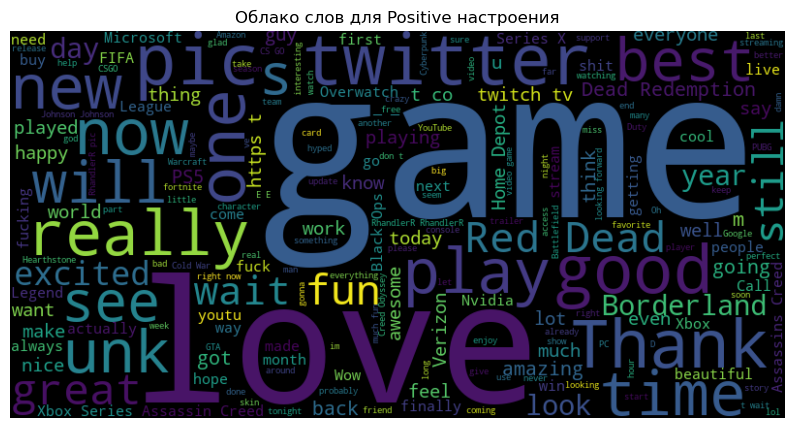

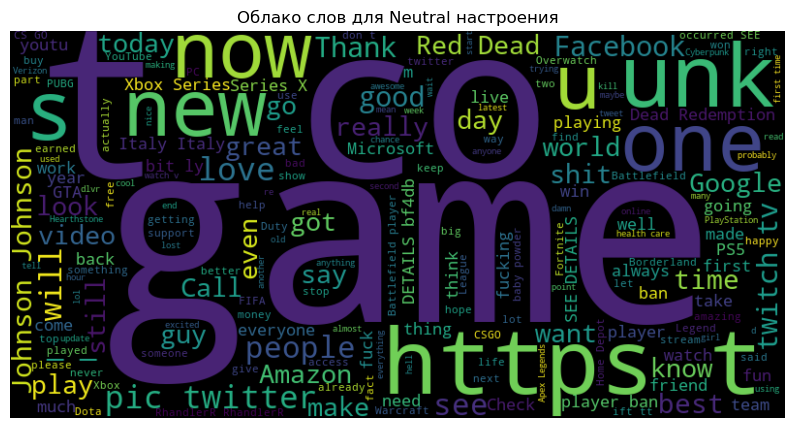

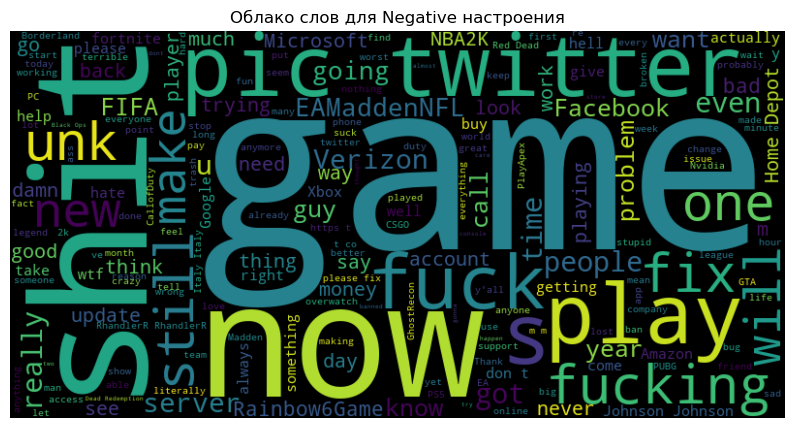

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def img_wordcloud(sentiment):

    txt_col = train_df[train_df["sentiment"] == sentiment]["Tweet content"]

    txt_col = txt_col.astype(str)

    # Join all into a single string
    text = ' '.join(txt_col)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов для {sentiment} настроения')
    plt.show()


sentiments = train_df['sentiment'].unique()
for sentiment in sentiments:
    img_wordcloud(sentiment)


<font color='green'>
     На позитивном и негативном слайде видны ярко окрашенные слова.
<br>
     Но в целом много каши и шума, т.к. слишком много разноплановых сущностей со своими частотными особенностями для словарей.
<br>  
     Посмотрим визуально в разрезе разных сущностей.

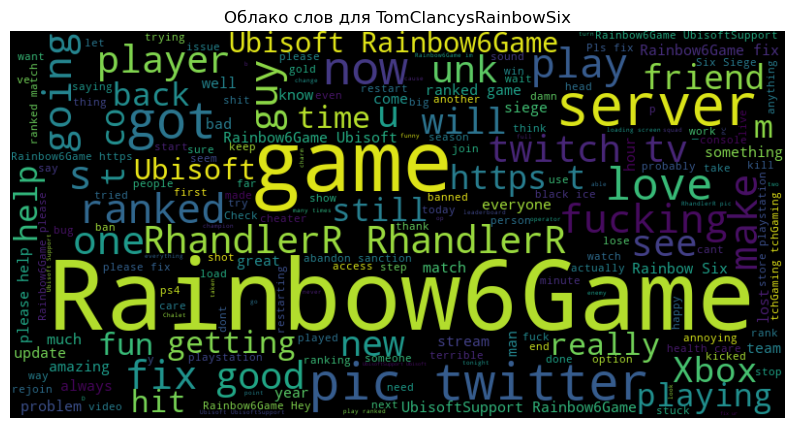

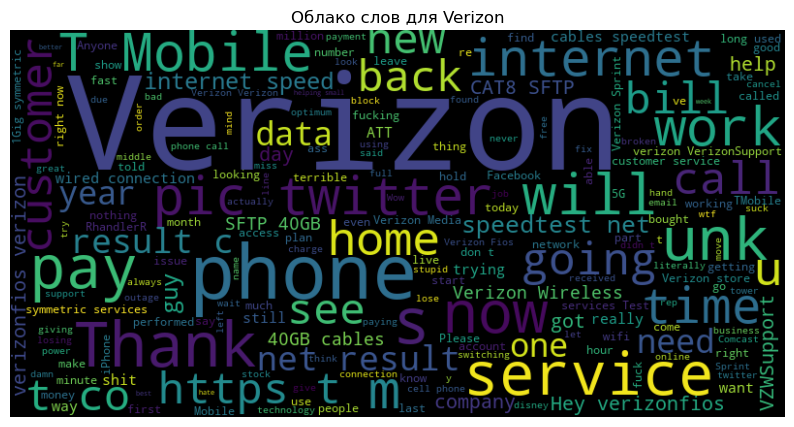

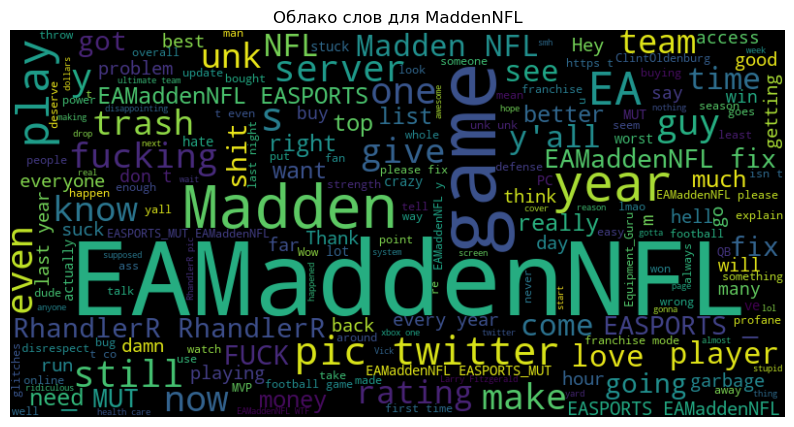

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Посчитаем кол-во твитов для каждой сущности
entity_counts = train_df['entity'].value_counts()

# Выберем 3 наиболее частые, хотя, как видели они более менее похожи
top_entities = entity_counts.head(3).index.tolist()

# Проитеррируемся по выбранным
for entity in top_entities:
    # Filter tweets associated with the current entity and extract the 'Tweet content' column
    txt_col = train_df[train_df['entity'] == entity]['Tweet content']

    # Convert the tweets to strings
    txt_col = txt_col.astype(str)

    # Join all into a single string
    text = ' '.join(txt_col)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов для {entity}')
    plt.show()


<font color='green'>
     Видимо, что бы оценить, нужно что то в этих сущностях понимать, но увы.
<br>
     Можно сказать, представление получили.
<br>  
     Проблем, которые могут помешать невыявлено. Можно приступать к обработке.

### 5.	Предобработка и токенизация.

In [ ]:
def preprocess_text(text):
    # Токенизируем
    tokens = word_tokenize(text.lower())
    # Удаляем стопслова и пунктуацию
    stop_words = set(stopwords.words('english') + list(string.punctuation))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

<font color='green'>
     Применим функцию предобработки к столбцу датафрейма.
<br>

In [ ]:
train_df['Tweet content']=train_df['Tweet content'].astype('str')
train_df['clean_text'] = train_df['Tweet content'].apply(preprocess_text)

### 6.	Преобразование текста в векторное пространство.

<font color='green'>
        Кодируем целевую метку.
<br>

In [ ]:
lab_enc = LabelEncoder()
train_df['label'] = lab_enc.fit_transform(train_df['sentiment'])

In [ ]:
train_df.head()

,TweetID,entity,sentiment,Tweet content,clean_text,label
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,2


<font color='green'>
     Разделим тренировочную выборку на обучающий и тестовый наборы.
<br>

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'], train_df['label'], test_size=0.2, random_state=42)


<font color='green'>
        Векторизуем текст.
<br>

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

<font color='green'>
        Готовим и векторизуем данные по валидационной выборке.
<br>

In [ ]:
val_df['clean_text'] = val_df['Tweet content'].apply(preprocess_text)

X_valid_data = vectorizer.transform(val_df['clean_text'])

y_valid_data = val_df.sentiment


### 7.	Применение модели логистической регрессии и оценка результатов.

<font color='green'>
        Построим и обучим модель логистической регрессии.
<br>

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<font color='green'>
        Оценим предсказания модели логистической регрессии.
<br>

In [ ]:
y_pred = lr.predict(X_val_vec)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.8207382597166981
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      4433
           1       0.79      0.87      0.83      5987
           2       0.82      0.75      0.79      3911

    accuracy                           0.82     14331
   macro avg       0.83      0.81      0.82     14331
weighted avg       0.82      0.82      0.82     14331



<font color='green'>
        Оценим предсказания логистической регрессии на валидационной выборке.
<br>

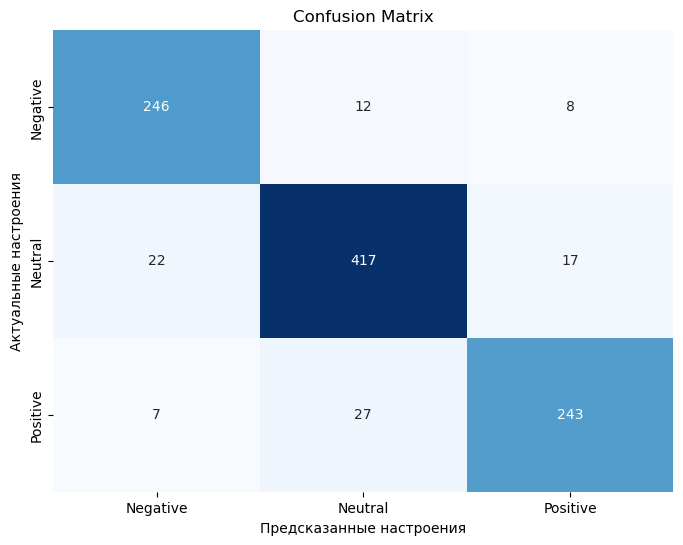

              precision    recall  f1-score   support

    Negative       0.89      0.92      0.91       266
     Neutral       0.91      0.91      0.91       456
    Positive       0.91      0.88      0.89       277

    accuracy                           0.91       999
   macro avg       0.91      0.91      0.91       999
weighted avg       0.91      0.91      0.91       999

Accuracy: 0.9069069069069069


In [ ]:
y_valid_data_pred = lab_enc.inverse_transform(lr.predict(X_valid_data))

pred_df = pd.DataFrame({'Predicted Sentiment': y_valid_data_pred})
pred_df.to_csv('data_out/predicted_sentiments_LR.csv', index=False)

accuracy = accuracy_score(y_valid_data, y_valid_data_pred)

confusion = confusion_matrix(y_valid_data, y_valid_data_pred)

classification = classification_report(y_valid_data, y_valid_data_pred)

le = LabelEncoder()
le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'>
        При использовании токенизатора nltk.tokenize и векторизатора TfidfVectorizer на логистической регрессии получили результат Accuracy: 0.9069.
<br>
    Попрорбуем улучшить этот результат за счет применения лемматизации .

### 8.	Лемматизация.

In [ ]:
train_df.head()

,TweetID,entity,sentiment,Tweet content,clean_text,label
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,2


In [ ]:
wnl = WordNetLemmatizer()
wnl.lemmatize('resumed', pos='v')

'resume'

In [ ]:
def lemm_preprocess_text(text):
    lms = []
    for word in text.split():
        lms.append(wnl.lemmatize(word, pos='v'))
    return ' '.join(lms)
train_df['clean_text']=train_df['clean_text'].astype('str')
train_df['lemms'] = train_df['clean_text'].apply(lemm_preprocess_text)

val_df['clean_text']=val_df['clean_text'].astype('str')
val_df['lemms'] = val_df['clean_text'].apply(lemm_preprocess_text)

train_df.head()

,TweetID,entity,sentiment,Tweet content,clean_text,label,lemms
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,2,come border kill
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,2,im get borderlands kill
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,2,im come borderlands murder
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,2,im get borderlands 2 murder
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,2,im get borderlands murder


<font color='green'>
 Удалим значения NaN, образовавшиеся из пустых строк после токенизации и лемматизации.  
<br>
<br>

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71655 entries, 0 to 74680
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        71655 non-null  int64 
 1   entity         71655 non-null  object
 2   sentiment      71655 non-null  object
 3   Tweet content  71655 non-null  object
 4   clean_text     71655 non-null  object
 5   label          71655 non-null  int64 
 6   lemms          71655 non-null  object
 7   emb_w2v        71655 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.9+ MB


In [ ]:
train_df = train_df.loc[train_df['lemms'] != '']

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70198 entries, 0 to 74680
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        70198 non-null  int64 
 1   entity         70198 non-null  object
 2   sentiment      70198 non-null  object
 3   Tweet content  70198 non-null  object
 4   clean_text     70198 non-null  object
 5   label          70198 non-null  int64 
 6   lemms          70198 non-null  object
 7   emb_w2v        70198 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.8+ MB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        999 non-null    int64 
 1   entity         999 non-null    object
 2   sentiment      999 non-null    object
 3   Tweet content  999 non-null    object
 4   clean_text     999 non-null    object
 5   lemms          999 non-null    object
 6   emb_w2v        999 non-null    object
dtypes: int64(1), object(6)
memory usage: 62.4+ KB


In [ ]:
val_df = val_df.loc[val_df['lemms'] != '']

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 998
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TweetID        998 non-null    int64 
 1   entity         998 non-null    object
 2   sentiment      998 non-null    object
 3   Tweet content  998 non-null    object
 4   clean_text     998 non-null    object
 5   lemms          998 non-null    object
 6   emb_w2v        998 non-null    object
dtypes: int64(1), object(6)
memory usage: 62.4+ KB


In [ ]:
train_df.to_csv('data_out/train_df.csv', index=False)
val_df.to_csv('data_out/val_df.csv', index=False)

In [ ]:
#test_db = pd.read_csv('data_out/train_df.csv')
#test_db.head()

<font color='green'>
        Снова применим логистическую регрессию и оценим результат.
<br>

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['lemms'], train_df['label'], test_size=0.2, random_state=42)


<font color='green'>
        Векторизуем текст.
<br>

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

<font color='green'>
        Готовим и векторизуем данные по валидационной выборке.
<br>

In [ ]:
X_valid_data = vectorizer.transform(val_df['lemms'])
y_valid_data = val_df.sentiment

<font color='green'>
        Построим и обучим модель логистической регрессии.
<br>

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<font color='green'>
        Оценим предсказания модели логистической регрессии.
<br>

In [ ]:
y_pred = lr.predict(X_val_vec)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.8051775870490545
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4433
           1       0.78      0.86      0.82      5987
           2       0.80      0.74      0.77      3911

    accuracy                           0.81     14331
   macro avg       0.81      0.80      0.80     14331
weighted avg       0.81      0.81      0.80     14331



<font color='green'>
        Оценим предсказания логистической регрессии на валидационной выборке.
<br>

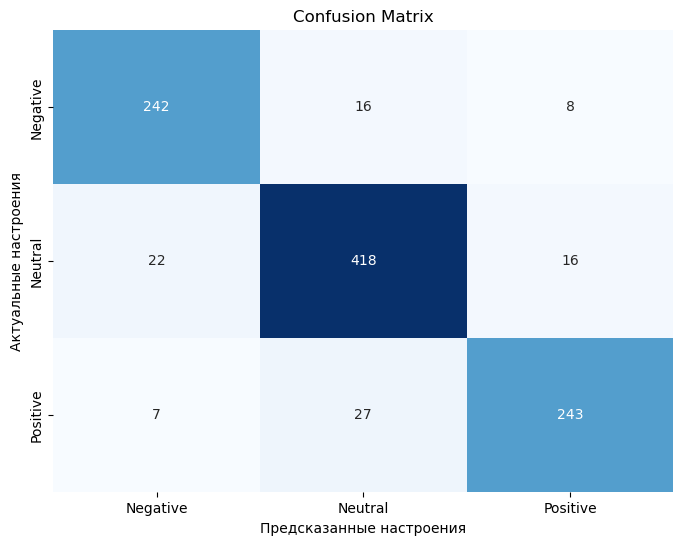

              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90       266
     Neutral       0.91      0.92      0.91       456
    Positive       0.91      0.88      0.89       277

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999

Accuracy: 0.9039039039039038


In [ ]:
y_valid_data_pred = lab_enc.inverse_transform(lr.predict(X_valid_data))

pred_df = pd.DataFrame({'Predicted Sentiment': y_valid_data_pred})
pred_df.to_csv('data_out/predicted_sentiments_LR_lemms.csv', index=False)

accuracy = accuracy_score(y_valid_data, y_valid_data_pred)

confusion = confusion_matrix(y_valid_data, y_valid_data_pred)

classification = classification_report(y_valid_data, y_valid_data_pred)

le = LabelEncoder()
le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'>
        Результат оказался хуже чем, до лемматизации.
<br>
    Видимо, приведя к стандартной форме слова мы убрали некоторую детализацию эмоционального окраса за счет крепких устойчивых устных выражений и тому подобному.
<br>
    Сохраним результат лемматизации, т.к. собираемся в будущем его использовать для несколько других целей.
<br>
    А сейчас посмотрим, может ли применение более продвинутой векторизации word2vec по предробученной модели от Google (GoogleNews-vectors-negative300) улучшить этот результат. Как та же логистическая регрессия отработает с векторизацией word2vec на корпусе с леммитизацией.

### 9.	Применение векторизации word2vec по предробученной модели от Google и оценка результатов.

In [ ]:
import gensim
#Loading the word vectors from Google trained word2Vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True,)


In [ ]:
GoogleModel['hello'].shape

(300,)

In [ ]:
'Hello' in GoogleModel.key_to_index.keys()

True

In [ ]:
def get_text_embedding(text):
    result = []
    for word in text.split():
        if word in GoogleModel.key_to_index.keys():
            result.append(GoogleModel[word])

    if len(result):
        result = np.sum(result, axis=0)
    else:
        result = np.zeros(300)
    return result

In [ ]:
train_df['lemms']=train_df['lemms'].astype('str')
train_df['emb_w2v'] = train_df['lemms'].apply(get_text_embedding)

val_df['lemms']=val_df['lemms'].astype('str')
val_df['emb_w2v'] = val_df['lemms'].apply(get_text_embedding)

train_df.head()

,TweetID,entity,sentiment,Tweet content,clean_text,label,lemms,emb_w2v
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill,2,come border kill,"[-0.09283447, 0.4025879, 0.22436523, 0.1259765..."
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill,2,im get borderlands kill,"[-0.13763428, -0.091918945, 0.07324219, 0.6435..."
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder,2,im come borderlands murder,"[-0.21130371, -0.012634277, 0.6118164, 0.51367..."
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,2,im get borderlands 2 murder,"[-0.09301758, -0.2687378, 0.32470703, 0.571777..."
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder,2,im get borderlands murder,"[-0.19995117, -0.16326904, 0.27148438, 0.50195..."


In [ ]:
train_df.to_csv('data_out/train_df.csv', index=False)
val_df.to_csv('data_out/val_df.csv', index=False)

<font color='green'>
        Снова применим логистическую регрессию и оценим результат.
<br>

In [ ]:
features = [text for text in tqdm(train_df['emb_w2v'])]

100%|████████████████████████████████| 71655/71655 [00:00<00:00, 2536183.80it/s]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features, train_df['label'], test_size=0.2, random_state=42)


<font color='green'>
        Готовим и векторизуем данные по валидационной выборке.
<br>

In [ ]:
#X_valid_data = val_df['emb_w2v']

X_valid_data = [text for text in tqdm(val_df['emb_w2v'])]

y_valid_data = val_df.sentiment


100%|████████████████████████████████████| 999/999 [00:00<00:00, 1890843.73it/s]


<font color='green'>
        Построим и обучим модель логистической регрессии.
<br>

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/home/avm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<font color='green'>
        Оценим предсказания модели логистической регрессии.
<br>

In [ ]:
y_pred = lr.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.5944456074244644
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      4433
           1       0.56      0.67      0.61      5987
           2       0.59      0.51      0.55      3911

    accuracy                           0.59     14331
   macro avg       0.60      0.58      0.59     14331
weighted avg       0.60      0.59      0.59     14331



<font color='green'>
        Оценим предсказания логистической регрессии на валидационной выборке.
<br>

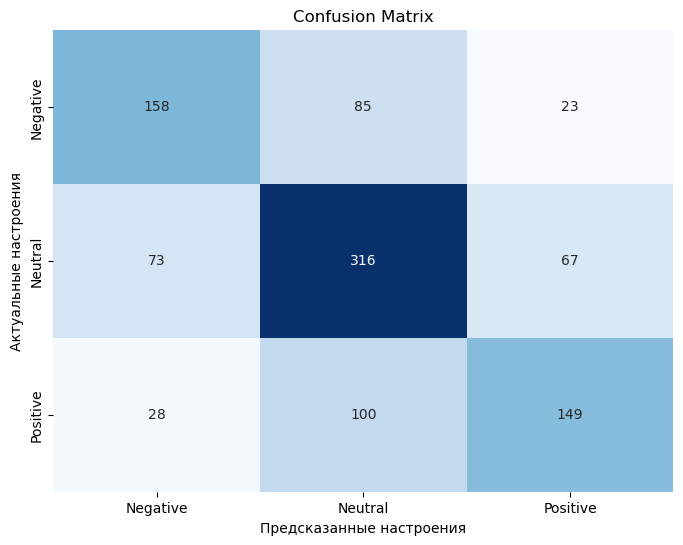

              precision    recall  f1-score   support

    Negative       0.61      0.59      0.60       266
     Neutral       0.63      0.69      0.66       456
    Positive       0.62      0.54      0.58       277

    accuracy                           0.62       999
   macro avg       0.62      0.61      0.61       999
weighted avg       0.62      0.62      0.62       999

Accuracy: 0.6236236236236237


In [ ]:
y_valid_data_pred = lab_enc.inverse_transform(lr.predict(X_valid_data))

pred_df = pd.DataFrame({'Predicted Sentiment': y_valid_data_pred})
pred_df.to_csv('data_out/predicted_sentiments_LR_lemms_word2vec.csv', index=False)

accuracy = accuracy_score(y_valid_data, y_valid_data_pred)

confusion = confusion_matrix(y_valid_data, y_valid_data_pred)

classification = classification_report(y_valid_data, y_valid_data_pred)

le = LabelEncoder()
le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'>
        Полученный результат можно назвать катастрофическим.
<br>
    Точность предсказаний еле дотягивает до 60 процентов.
<br>
    Сначала мы снизили точность прогноза убрав некоторые особенности текстов лемматизацией, а потом векторизовали слова в этих лемматизированных текстах с помощью предобученной модели wor2vec от Google. Эта модель было обучена на очень большом корпусе новостей, но их тематика слишком далеко лежит от тематики наших твитов. В результате точность предсказаний логистической регрессии кординально снизилась.
<br>
    Можно сделать вывод, что для наших целей лучше подходит использование токенизатора nltk.tokenize и векторизатора TfidfVectorizer. Так как TfidfVectorizer работает именно с корпусом наших документов, результат его работы более актуален для задач классификации. К тому же он проще и скорость обработки таким образом выше.
<br>
    Во второй части работы я попробую поднять метрику классификации за счет использования разных классификаторов с разными вариациями параметров.
<br>
    В третьей части работы, есть идея попробовать выделить сущности, на которые конкретно жалуются клиенты,за счет построения модели wor2vec на леммитизированных корпусах, выбранных из общего корпуса по признакам конкретного entity и конкретного спрогнозированного строго положительного или отрицательного отзыва. Дальше выбираются из этого корпуса наиболее часто встречающиеся сущности через from collections import Counter, вычищается общий для всех запросов шум на основе общего словаря "мусорных слов", оставляются из оставшихся только существительные и глаголы, и по списку топ 10 выводятся наиволее близкие по рассчитанной модели wor2vec парные слова. Все это заностися в датафрейм и выдается на просмотр маркетологу. Как бы задача от противного - обычно для большой задачи/темы строится свой конкретный тематический словарь для онализа этой области. А поскольку у нас здесь много разноплановых сущностей, то я решил попробовать построить общий для всех фильтр шума, который уберет общеупотребительную лексику, но надеюсь оставит информативные сущности из разных тем. С чистотой будет не очень, но зато один словарь шума и один алгоритм обработки для разных тем. А для ручного просмотра финишного варианта "в помощь маркетологу" думаю работать будет.
   
<br>
    Можно еще четвертой частью обучить небольшую нейронку на обсчет конкретно этого векторизированного корпуса, если время останется и Вы считаете это актуальным. Рекорда добиться не смогу, но потренироваться можно :)